### Predgovor
Ova vježba sastoji se od teoretskog i praktičnog dijela. Bez adekvatnog teorijskog razumijevanja, izvedba vježbe biti će značajno izazovnija.

Predlažemo da napravite kopiju ove bilježnice na svoj Colab profil i tamo riješite vježbu. Ne zaboravite uključiti GPU akceleraciju (Runtime->Change runtime type->GPU->Save). \

U slučaju nejasnoća javite se na anja.delic@fer.hr.

# 4. Laboratorijska vježba - generativno modeliranje

Jedan od glavnih katalizatora u razvoju modernog računalnog vida jest dostupnost velikih skupova podataka. Iako su skupovi podataka lako dostupni, proces koji generira podatke je često nepoznat. Cilj ove laboratorijske vježbe jest pokušati aproksimirati proces koji generira dani skup podataka.


## Teorijska podloga generativnom modeliranju

Krenuti ćemo od bolje definicije zadatka.
Pretpostavimo postojanje skupa podataka $D=\{\mathbf{x}_i\}_{i=1}^N$ koji je nastao uzorkovanjem nepoznate distribucije $P_D(\underline{\mathbf{x}})$. Nadalje, pretpostavimo da je svaki primjer $\mathbf{x}_i$ dobiven nezavisnim uzorkovanjem. Naš cilj je aproksimirati nepoznatu distribuciju podataka $P_D(\underline{\mathbf{x}})$ poznatim modelom $P_\theta(\underline{\mathbf{x}})$.
S obzirom da su naši podaci često u kontinuirani ($\underline{\mathbf{x}}$ je kontinuirana slučajna varijabla) baviti ćemo se modeliranjem gustoća vjerojatnosti $p_D(\underline{\mathbf{x}})$ i $p_\theta(\underline{\mathbf{x}})$.

**Problem 1.:** Kako poravnati nepoznati $p_D(\underline{\mathbf{x}})$ i poznati $p_\theta(\underline{\mathbf{x}})$?



U teoriji vjerojatnosti, različitost između dvije distribucije $P(\underline{x})$ i $Q(\underline{x})$ se mjeri pomoću f-divergencije. Jedna od najčešćih mjera iz obitelji f-divergencija je KL-divergencija. KL-divergenciju za kontinuirane slučajne varijable definiramo kao:
$$
\mathrm{KL}(P, Q) = \int_{-\infty}^{+\infty} p(x) \ln\frac{p(x)}{q(x)} dx.
$$
$p$ i $q$ su pripadajuće gustoće vjerojatnosti.

KL-divergencije između distribucije podataka i distribucije modela je primamljiv gubitak za naš optimizacijski postupak. Može se pokazati da je minimizacija KL divergencije između distribucije podataka i distribucije modela ekvivalentna minimizaciji negativne log-izglednosti skupa podataka za učenje:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) \simeq \underset{\theta}{\mathrm{min}} \, -\mathbb{E}_{\mathbf{x} \in D} \;\;  [\ln p_\theta(\mathbf{x})]
$$

**Zadatak 1.**: Dokažite navedenu tvrdnju.

Dokaz:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) = \mathrm{Nadopuni}
$$


**Problem 2.**: Definicija modela $p_\theta$.

Naš sljedeći korak je definirati model $p_\theta$. Upravo po definiciji  $p_\theta$ razlikujemo različite generativne modele.
Na primjer autoregresivna faktorizacija modela dovodi do autoregresijskih modela, dok modeliranje nenormalizirane distribucije dovodi do energijskih modela. U ovoj vježbi se fokusiramo  na vrstu generativnih modela koje nazivamo normalizirajući tokovi. Normalizirajući tok $p_\theta$ definiramo pomoću formule za zamjenu varijabli distribucije.

Pretpostavimo da su $\underline{\mathbf{x}}$ i $\underline{\mathbf{z}}$ dvije kontinuirane slučajne varijable. Pretpostavimo da bijekcija $f$ mapira realizacije slučajne varijable $\underline{\mathbf{x}}$ u realizacije od $\underline{\mathbf{z}}$, to jest $\mathbf{z} = f(\mathbf{x})$. S obzirom da je $f$ bijekcija vrijedi i obrat $\mathbf{x} = f^{-1}(\mathbf{z})$. Formulu za zamjenu varijabi distribucije definiramo kao:
$$
 p(\mathbf{x}) = q(\mathbf{z}) \left| \mathrm{det} \frac{\partial \mathbf{z}}{ \partial \mathbf{x}} \right|, \quad \mathbf{z} = f(\mathbf{x})
$$
$\frac{∂ \mathbf{z}}{ ∂ \mathbf{x}}$ predstavlja Jakobijan funkcije $f$ za $\textbf{x}$. det predstavlja determinantu. $|\cdot|$ predstavlja apsolutnu vrijednost.
To jest, drugi član umnoška odgovara apsolutnoj vrijednosti determinante Jakobijana transformacije $f$.

Formulu za zamjenu varijabli ćemo iskoristiti za izgradnju okvira koji nam omogućava implementaciju dubokog generativnog modela.
Ideja je jednostavna, distribuciju $q(\mathbf{z})$ možemo predefinirati (npr. kao Gaussovu distribuciju). Tada nam je jedina nepoznanica bijekcija $f$ koju možemo parametrizirati s $\theta$ te naučiti optimizacijskim postupkom.


Prisjetimo se sljedećih teorema:
1. kompozicija bijekcija je bijekcija, tj $f$ možemo raspisati kao $f = f_1 ∘ f_2 ∘ f_3 ∘ \dots \circ f_K$.
2. pravilo ulančavanja: $\frac{∂ z_3}{ ∂ z_1} = \frac{∂ z_3}{ ∂ z_2}\frac{∂ z_2}{ ∂ z_1} $
3. determinanta umnoška dviju kvadratnih matrica istog reda jednaka je umnošku determinanti svake matrice (Binet-Cauchyjev teorem)
4. Apsolutna vrijednost umnoška dva realna broja je jednaka umnošku apsolutnih vrijednosti: $|a\cdot b| = |a|\cdot |b|$

Bijekciju $f$ možemo promatrati kao kompoziciju funkcija, gdje svaka funkcija $f_i$ prima varijablu $z_{i-1}$ i računa varijablu $z_i$.
Ako uzmemo u obzir prethodno spomenute teoreme, dolazimo do sljedeće formulacije:
$$
 p_\theta (\mathbf{x}) = q(\mathbf{z}_K) \prod_{k=1}^K \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$
gdje je $\mathbf{z}_{0} = \mathbf{x}$.
$q(\mathbf{z}_K)$ može biti proizvoljna distribucija pa je definiramo kao $q(\mathbf{z}_K):= \mathcal{N}(\mathbf{z}_K; 0, \mathrm{I})$.

**Zadatak 2.** Krenuvši od općenite formule za zamjenu varijabli izvedite izraz za normalizirajući tok.

Izvod:
$$
p(\mathbf{x}) = q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f(\mathbf{x})}{ \partial \mathbf{x}} \right| \\ \dots
$$

Spomenimo još da nas općenito zanima logaritam gustoće vjerojatnosti pa pišemo:
$$
 \ln p_\theta (\mathbf{x}) = \ln q(\mathbf{z}_K) +\sum_{k=1}^K \ln \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}), \tag{1}
$$

Ostala nam je još jedna nepoznanica, a to je dizajn funkcija $f_k$,  $k=1,...,K$.
Dizajn funkcije f ovisi o podacima koje modeliramo. Razmislite kako biste bijekciju modelirali kao gradivni blok dubokog modela.

## Modeliranje 2D skupa podataka normalizirajućim tokom

**Problem 3.** Modeliranje 2D skupa podatka.

In [ ]:
import os
import torch
import random
import numpy as np
import torch.nn as nn

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

import matplotlib.pyplot as plt

In [ ]:
class GaussianMixture2DDataset:
    def __init__(self, num_samples, n_comp=2, loc=torch.zeros(2,2), scale=torch.ones(2,2), pi=(torch.ones(2)/2)):
        samples_per_component = (pi * num_samples).long()
        self.samples = torch.cat([torch.randn(samples_per_component[i],2) * scale[i] + loc[i] for i in range(n_comp)], 0)

    def __getitem__(self, idx):
        return self.samples[idx]

Promotrimo sljedeći skup podataka. Pretpostavimo da nam je dostupan samo skup podataka $D$. Cilj nam je aproksimirati distribuciju podataka $p_D$ pomoću normalizirajućeg toka.

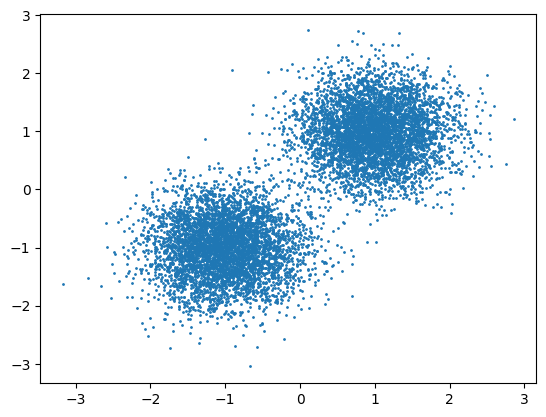

In [ ]:
D = GaussianMixture2DDataset(9999, loc=torch.tensor([[-1, -1], [1,1]]), scale=torch.tensor([[0.5, 0.5], [0.5,0.5]])).samples
plt.scatter(D[:, 0], D[:, 1], 1)
plt.show()

S obzirom da modeliramo 2D skup podatka, zanimaju nas funkcije s domenom $\mathbb{R}^2$ i kodomenom $\mathbb{R}^2$ koje imaju inverz.
Definiramo sljedeći implementacijski ovir:

In [ ]:
class _Bijection(nn.Module):
    def __init__(self):
        super(_Bijection, self).__init__()

    def forward(self, x):
        pass

    def inverse(self, z):
        pass

Funkcija `forward` implementira unaprijedni prolaz kroz sloj i na izlazu vraća transformirani ulaz i logaritam apsolutne vrijednosti determinante Jakobijana funkcije. \
Funkcija `inverse` implementira inverzni probalz kroz sloj i na izlazu vraća transformirani ulaz.

**Zadatak 3.**: Pokušajmo ponuditi bijektivnu alternativu sloju torch.nn.Linear za dvodimenzionalne podatke. Obratite pozornost na to da je transformaciju potrebno održavati invertibilnom regularizacijskim članom.
Nadopunite forward i inverse funkciju.

Uputa: Linearna transformacija se primjenjuje na svaki primjer u minigrupi nezavisno. Zbog malene dimenzionalnosti, invertiranje i računanje determinante Jakobijana možemo izvesti grubom silom, izravnim pozivom odgovarajućih funkcija torcha.

In [ ]:
def sum_except_batch(x, num_dims=1):
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

class BijectiveLinear(_Bijection):
    def __init__(self, dim):
        super(BijectiveLinear, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.eye(dim))
        self.bias = nn.Parameter(torch.zeros(1, dim))

    def forward(self, x):  # x has shape NxD
        z = x @ self.weight + self.bias
        # det(A) == det(A.T) so there is no reason to add .T
        log_abs_det_weight = (self.weight.det().abs() + 1e-9).log()

        log_abs_det = log_abs_det_weight.expand(x.size(0))
        return z, log_abs_det  # shapes NxD, N

    def inverse(self, z):
        x = (z - self.bias) @ self.weight.inverse()
        return x  # NxD

    def regularization(self):
        return ((self.weight.T @ self.weight) - torch.eye(self.dim)).abs().sum()


**Zadatak 4.**: Nadopunjavanje izvedbe osnovnog razreda `NormalizingFlow`.

Proučite predloženu nepotpunu izvedbu razreda `NormalizingFlow`. Obratite pozornost na to da konstruktor razreda prima argument `transforms` koji mora biti tipa [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) kako bismo kroz taj objekt mogli iterirati pri unaprijednom i inverznom prolazu. Iteraciju ćemo provoditi `for` petljom i tako prolaziti kroz slojeve normalizirajućeg toka. Predložite potpunu izvedbu razreda `NormalizingFlow` pod pretpostavkom da svi elementi slijednog modela `transforms` nasljeđuju prethodno definirano sučelje `_Bijection`. Vaše rješenje može dodavati nove lokalne metode razredu `NormalizingFlow`.



In [ ]:
class NormalizingFlow(nn.Module):
    """
    Base class for normalizing flow.
    """

    def __init__(self, transforms, input_dim):
        super().__init__()
        self.transforms = transforms  # has to be of type nn.Sequential.

        self.register_buffer("loc", torch.zeros(input_dim))
        self.register_buffer("log_scale", torch.zeros(input_dim))
        self.base_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))

    def _get_base_dist_on_device(self, device):
        if self.base_dist.loc.device != device:
            self.base_dist = torch.distributions.Normal(
                self.loc.to(device), torch.exp(self.log_scale.to(device))
            )
        return self.base_dist

    def forward(self, x):
        """Transforms the input sample to the latent representation z.

        Args:
            x (torch.Tensor): input sample

        Returns:
            torch.Tensor: latent representation of the input sample
        """
        z = x
        for t in self.transforms:
            z, _ = t.forward(z)
        return z

    def inverse(self, z):
        """Transforms the latent representation z back to the input space.

        Args:
            z (torch.Tensor): latent representation

        Returns:
            torch.Tensor: representation in the input space
        """
        x = z
        for t in reversed(self.transforms):
            x = t.inverse(x)
        return x

    def log_prob(self, x):
        """Calculates the log-likelihood of the given sample x (see equation (1)).

        Args:
            x (torch.Tensor): input

        Returns:
            torch.Tensor: log-likelihood of x
        """
        if len(x.shape) < 2:
            x = x.unsqueeze(0)  # add batch dim

        self._get_base_dist_on_device(x.device)
        N = x.shape[0]
        z = x
        log_abs_det = torch.zeros(N).to(x.device)
        for t in self.transforms:
            z, log_abs_deti = t.forward(z)
            log_abs_det += log_abs_deti

        log_pz = sum_except_batch(self.base_dist.log_prob(z))
        log_px = log_pz + log_abs_det
        return log_px

    def sample(self, num_samples, T=1):
        """Generates new samples from the normalizing flow.

        Args:
            num_samples (int): number of samples to generate
            T (float, optional): sampleing temperature. Defaults to 1.

        Returns:
            torch.Tensor: generated samples
        """
        z = self.base_dist.sample(torch.Size([num_samples])) * T
        x = z
        for t in reversed(self.transforms):
            x = t.inverse(x)
        return x


U jednostavnom slučaju, transformaciju normalizirajućeg toka možemo definirati kao slijed linearnih transformacija:

In [ ]:
class SimpleNF(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for _ in range(num_steps):
            transforms.append(BijectiveLinear(input_dim))

        super(SimpleNF, self).__init__(transforms=transforms, input_dim=input_dim)

    def gather_regularization(self):
        return sum([m.regularization() for m in self.transforms])

Provjerite svoju implementaciju inverza sljedećim kodom:

In [ ]:
flow = SimpleNF(2, num_steps=7)
print((flow.inverse(flow(D)) - D).abs().sum().item())
assert (flow.inverse(flow(D)) - D).abs().sum() < 1e-9

0.0


Tok učimo optmizacijom prethodno objašnjenog gubitka.

In [ ]:
flow = SimpleNF(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-1)

for iter in range(4000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    loss_reg = flow.gather_regularization()
    total_loss = loss + 0.001 * loss_reg
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()} Reg:{loss_reg.item()}")

Iter 1: Loss:3.0862061977386475 Reg:0.0
Iter 21: Loss:2.5466935634613037 Reg:3.0696239471435547
Iter 41: Loss:2.576000690460205 Reg:3.1122183799743652
Iter 61: Loss:2.548900842666626 Reg:3.1993513107299805
Iter 81: Loss:2.5468132495880127 Reg:3.2017550468444824
Iter 101: Loss:2.5466501712799072 Reg:3.1980996131896973
Iter 121: Loss:2.5466346740722656 Reg:3.194186210632324
Iter 141: Loss:2.546633243560791 Reg:3.1903836727142334
Iter 161: Loss:2.546633243560791 Reg:3.1867010593414307
Iter 181: Loss:2.546632766723633 Reg:3.1831319332122803
Iter 201: Loss:2.546633005142212 Reg:3.1796698570251465
Iter 221: Loss:2.546632766723633 Reg:3.176311492919922
Iter 241: Loss:2.546632766723633 Reg:3.1730525493621826
Iter 261: Loss:2.546632766723633 Reg:3.169891357421875
Iter 281: Loss:2.546632766723633 Reg:3.166823148727417
Iter 301: Loss:2.5466322898864746 Reg:3.163846969604492
Iter 321: Loss:2.546633005142212 Reg:3.160959482192993
Iter 341: Loss:2.546633005142212 Reg:3.1581573486328125
Iter 361: Los

Ako ste do sada sve napravili kako treba, predloženi postav trebao bi uspjeti naučiti tok s gubitkom od oko 2.5.

Provjerimo još jednom stabilnost inverza. Kako biste komentrali rezultate?

In [ ]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(-2.4217e-05, grad_fn=<SumBackward0>)


In [ ]:
print((flow.inverse(flow(D)) - D).abs().sum())
assert (flow.inverse(flow(D)) - D).abs().sum() < 1e-4

tensor(0.0024, grad_fn=<SumBackward0>)


AssertionError: 

In [ ]:
-flow.log_prob(D).mean()

tensor(2.5494, grad_fn=<NegBackward0>)

Normalizirajućim tokom možemo generirati primjere na sljedeći način:

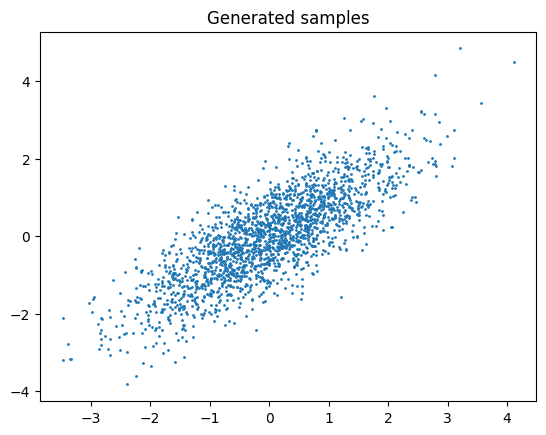

In [ ]:
X_ = flow.sample(2000).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.title("Generated samples")
plt.show()

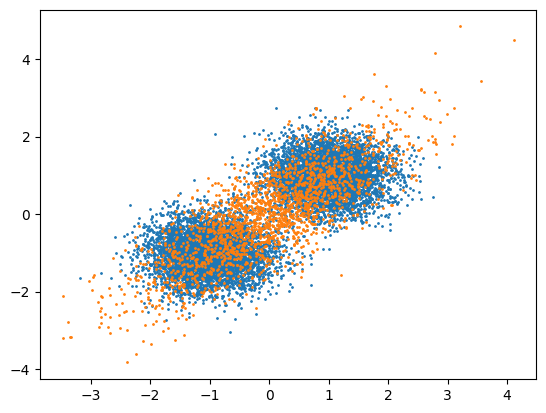

In [ ]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

Tok definiran razredom SimpleNF ne može ostvariti veliki kapacitet jer je kompozicija linearnih transformacija i dalje linearna transformacija. Stoga modelirana distribucija ne uspijeva dovoljno dobro aproksimirati $p_D$. Bolju aproksimaciju dobiti ćemo sofisticiranijom arhitekturom pod nazivom [RealNVP](https://arxiv.org/abs/1605.08803). RealNVP se sastoji od "slojeva" afinog miješanja koji su invertibilni po konstrukciji. Imajte na umu da afino miješanje tipično ostvarujemo s više slojeva dubokog modela jer modul miješanja `net` može sadržavati (i tipično sadrži) veći broj uzastopnih nelinearnih transformacija.

Unaprijedni prolaz kroz afino miješanje s ulazom $\mathbf{x}$ dimenzionalnosti $d$ definiramo kao ($m < d$):
$$
\mathbf{z}_{:m} = \mathbf{x}_{:m}
$$
$$
\mathbf{z}_{m:d} = \exp(\ln\mathbf{s}) \odot \mathbf{x}_{m:d} + \mathbf{t}, \quad \ln s, t = net(\mathbf{x}_{:m})
$$

**Zadatak 5.**: Skicirajte računske grafove unaprijednog i unatražnog prolaza kroz afino miješanje. \
Nadopunite predloženi razred `AffineCouplingLayer` s prikladnom funkcionalnošću.
Afino miješanje transformira samo polovicu ulaznog tezora $\mathbf{x}_{m:d}$, dok druga polovica $\mathbf{x}_{:m}$ ostaje nepromijenjena.
Modul miješanja `net` predviđa parametre miješanja `log_s` i `t` iz polovice ulaznog tenzora $\mathbf{x}_{:m}$.

In [ ]:
class AffineCouplingLayer(_Bijection):
    def __init__(self, net):
        super(AffineCouplingLayer, self).__init__()
        self.net = net

    def forward(self, x):  # NxD
        m = self.net.dim_in
        x1, x2 = x[:, :m], x[:, m:]
        log_s, t = self.net(x1)
        s = torch.exp(log_s)
        z1 = x1
        z2 = s * x2 + t

        log_det = torch.sum(log_s, dim=1)
        z = torch.cat([z1, z2], dim=1)
        return z, log_det  # NxD , N

    def inverse(self, y):  # NxD
        m = self.net.dim_in
        y1, y2 = y[:, :m], y[:, m:]
        x1 = y1
        log_s, t = self.net(x1)
        s = torch.exp(log_s)
        x2 = (y2 - t) / (s + 1e-7) # numerical stability

        x = torch.cat([x1, x2], dim=1)
        return x  # NxD

**Zadatak 6.:** Zamislimo situaciju gdje slijedno primjenjujemo više coupling slojeva. Možemo primijetiti da će se miješati samo jedna polovica tenzora. Kako bismo osigurali da se miješaju obje polovice ulaznog tenzora, uvodimo transformaciju `SwitchSides` koju ćemo primijeniti nakon svakog coupling sloja.
Na taj način osiguravamo da miješanje provodimo naizmjenično na dvjema polovicama ulaznog tenzora. \
Tenzor dijelimo po dimenziji značajki. Dovršite implementaciju razreda `SwitchSides` tako da dijeli ulazni tenzor na dva dijela po dimenziji značajki i zamjenjuje im strane. Možete iskoristiti funkcije [chunk](https://pytorch.org/docs/stable/generated/torch.chunk.html) i [cat](https://pytorch.org/docs/stable/generated/torch.cat.html).

In [ ]:
class SwitchSides(_Bijection):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        y = torch.cat([x2, x1], dim=1)
        return y, 0.0

    def inverse(self, z):
        """
        torch.chunk will add one element to the left side if there’s an odd number of elements.
        To ensure that inverse(forward(x)) == x, we then need to manually add an extra element
        to the right side during the inverse operation.
        torch.chunk automatically gives an extra element to the left side in forward,
        but for inverse we must manually give an extra element to the right side.
        """
        dim = z.shape[1]
        split_idx = dim // 2
        z1, z2 = z[:, :split_idx], z[:, split_idx:]
        x = torch.cat([z2, z1], dim=1)
        return x

In [ ]:
switch_sides = SwitchSides()
torch.allclose(switch_sides.inverse(switch_sides(D)[0]), D)

True

**Zadatak 7.:**U nastavku je dan razred `SimpleTransform` kojeg ćemo koristiti kao modul afinog miješanja u coupling sloju. Primijetite da će primjerci tog razreda biti atributi `net` razreda `AffineCouplingLayer`.\
Dovršite implementaciju tako da `model` bude potpuno povezani modul sljedeće arhitekture:

`fc(dim, internal_dim) -> relu -> fc(internal_dim, internal_dim) -> relu -> fc(internal_dim, 2*dim)`.

Dimenziju skrivenog sloja potpuno povezanog modula određujemo parametrom `inflate_coef`. \


Inicijalizirajte parametre modula miješanja tako da modul provodi transformaciju koja je jednaka identitetu. \

In [ ]:
class SimpleTransform(nn.Module):
    def __init__(self, dim_in, dim_out, inflate_coef=1):
        super(SimpleTransform, self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        internal_dim = int(dim_in * inflate_coef)

        """
        The final linear layer has a dimension of dim * 2 because we have dim parameters for log_s and dim parameters for t.
        Concatenate [log_scale, shift], it would be the same if we had two independent nets.
        It's similar to transfer learning where everything except the last layer is the same for both parameters,
        and only weights and biases for the last layer are different.
        """
        self.model = nn.Sequential(
            nn.Linear(dim_in, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, dim_out * 2),
        )

        """
        Since we want the identity matrix at the initialization of the NF, we actually want these conditions:
            1) t = 0
            2) exp(log_s) = 1 => log_s = 0
        So we can actually just set the last layer w *= 0, b *= 0.
        For stability, it might also be a good idea to set previous layers to smaller values.
        Not sure if this is a good idea.
        """
        with torch.no_grad():
            # for layer in self.model:
            #     if isinstance(layer, nn.Linear):
            #         layer.weight.zero_()
            #         layer.bias.zero_()

            last_linear_layer = self.model[-1]
            last_linear_layer.weight.zero_()
            last_linear_layer.bias.zero_()



    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t

In [ ]:
class SimpleRealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for i in range(num_steps):
            dim_in = input_dim // 2
            transforms.append(
                AffineCouplingLayer(SimpleTransform(dim_in, input_dim - dim_in))
            )
            if i != num_steps - 1:
                transforms.append(SwitchSides())
        super(SimpleRealNVP, self).__init__(transforms, input_dim)

Tok možemo naučiti na način kako slijedi:

In [ ]:
flow = SimpleRealNVP(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-2, nesterov=True, momentum=0.9)

for iter in range(4000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    total_loss = loss
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()}")

Iter 1: Loss:3.0862061977386475
Iter 21: Loss:3.053638458251953
Iter 41: Loss:3.0354361534118652
Iter 61: Loss:2.959836006164551
Iter 81: Loss:2.6046385765075684
Iter 101: Loss:2.5042879581451416
Iter 121: Loss:2.496544122695923
Iter 141: Loss:2.494014024734497
Iter 161: Loss:2.4920847415924072
Iter 181: Loss:2.4903039932250977
Iter 201: Loss:2.488503932952881
Iter 221: Loss:2.486572742462158
Iter 241: Loss:2.484443187713623
Iter 261: Loss:2.4821035861968994
Iter 281: Loss:2.4796135425567627
Iter 301: Loss:2.4770851135253906
Iter 321: Loss:2.47464656829834
Iter 341: Loss:2.4723081588745117
Iter 361: Loss:2.4700536727905273
Iter 381: Loss:2.46781587600708
Iter 401: Loss:2.4655189514160156
Iter 421: Loss:2.463148593902588
Iter 441: Loss:2.4607603549957275
Iter 461: Loss:2.458348274230957
Iter 481: Loss:2.4559578895568848
Iter 501: Loss:2.4536609649658203
Iter 521: Loss:2.4515645503997803
Iter 541: Loss:2.4497153759002686
Iter 561: Loss:2.4482226371765137
Iter 581: Loss:2.4471435546875
It

In [ ]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(-0.0018, grad_fn=<SumBackward0>)


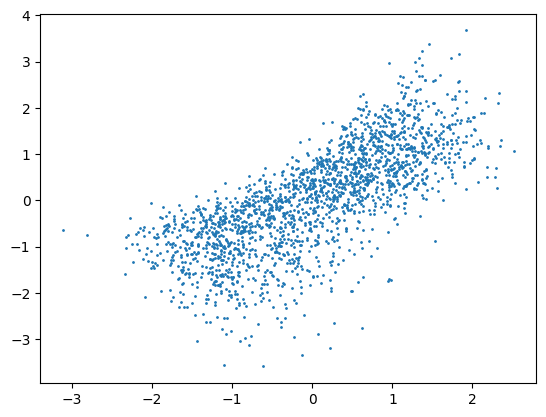

In [ ]:
X_ = flow.sample(2000, 1).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

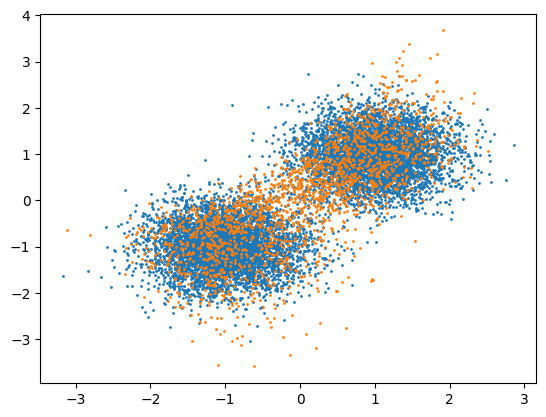

In [ ]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)

Kao što vidite, kapacitetniji tok uspijeva dobro aproksimirati dani skup podataka.

## Modeliranje slika normalizirajućim tokom

Naš sljedeći zadatak je modelirati distribuciju slika s normalizirajućim tokom. Slike možemo prestaviti diskretnim tenzorom $\mathbf{x} \in [0, 255]^{C \times H \times W}$. Prisjetimo se da smo normalizirajući tok definirali za kontinuirane slučajne varijable. Stoga, potrebno je transfrormirati skup podataka u kontinuiranu domenu pomoću zašumljivanja:

$$
\mathbf{y} = \mathbf{x} + \mathbf{u}, \quad \mathbf{u} \sim \mathrm{U}[0, 1)
$$
U prestavlja uniformnu razdiobu. Sada, naš model uči modelirati zašumljenu sliku. Više o dekvantizaciji zašumljivanjem možete pronaći [ovdje](https://arxiv.org/pdf/1511.01844.pdf).

MNIST je skup jednostavnih slika pa ćemo se sljedećim pojednostavljenjem. Sliku ćemo ispeglati u vektor i normalizirajućim tokom učiti takvu reprezentaciju slike.

U nastavku je dan kod za pripremanje skupa slika.

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as tf
from torch.utils.data import DataLoader, Subset

In [ ]:
# hyperparams
img_size = 14
batch_size = 128
selected_number = 0
lr = 1e-5
device = "cuda" if torch.cuda.is_available() else "cpu"
bits = 8
num_transforms = 21
num_iters = 1000
bits = 8
eval_iter_freq = 50

In [ ]:
train_ds = MNIST('.', train=True, download=True, transform=tf.Compose([tf.Resize(img_size), tf.ToTensor()]))
test_ds = MNIST('.', train=False, download=True, transform=tf.Compose([tf.Resize(img_size), tf.ToTensor()]))

loaders = {}
for selected_number in range(10):
    indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, train_ds[i][1]) for i in range(len(train_ds))]))]
    digit_train_ds = Subset(train_ds, indices)

    indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, test_ds[i][1]) for i in range(len(test_ds))]))]
    digit_test_ds = Subset(test_ds, indices)

    train_loader = DataLoader(digit_train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(digit_test_ds, batch_size=batch_size, shuffle=False)
    loaders[selected_number] = (train_loader, test_loader)

In [ ]:
def plot_mnist(samples, num_row, num_col):
    assert len(samples) ==  num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(len(samples)):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(samples[i], cmap='gray')
    plt.tight_layout()
    plt.show()

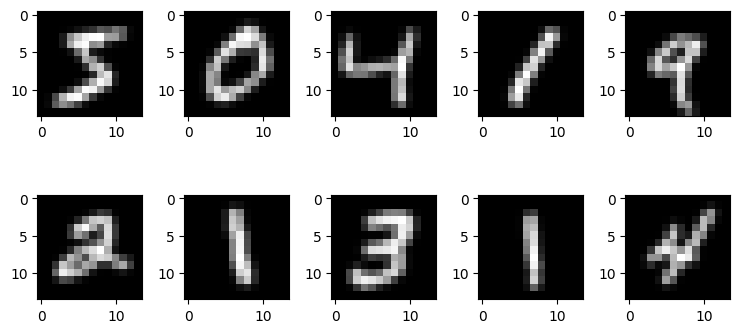

In [ ]:
samples = [train_ds[i][0][0] for i in range(10)]
plot_mnist(samples, 2, 5)

**Zadatak 8.:** Predložite arhitekturu toka koji će moći naučiti distribuciju vektoriziranih slika. Predlažemo koristiti rezidualni blok sljedeće arhitekture.

`fc(dim, dim) -> BN -> relu -> fc(dim, dim) -> relu`

Potrebno je dodati rezidualnu vezu od ulaza u rezidualni blok do latentne reprezentacije prije posljednje zglobnice.
Dovršite implementaciju i validirajte utjecaj batchnorma na proces učenja i konačne rezultate.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, use_bn=False):
        super(ResidualBlock, self).__init__()

        self.layers = nn.Sequential()
        self.layers.append(nn.Linear(dim, dim))
        if use_bn:
            self.layers.append(nn.BatchNorm1d(dim))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(dim, dim))
        self.f_relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.layers(x)
        out = out + identity
        return self.f_relu(out)

**Zadatak 9.:** Po uzoru na razred `SimpleTransform` dovršite implementaciju razreda `SimpleResidualTransform` čiji se modul miješanja sastoji od rezidualnih blokova. Predlažemo sljedeću arhitekturu:

`fc(dim, internal_dim) -> relu -> res_block(internal_dim, internal_dim) -> fc(internal_dim, 2*dim)`

Eksperimentirajte s brojem rezidualnih blokova. Kako broj rezidualnih blokova utječe na rezultate?

In [ ]:
class SimpleResidualTransform(nn.Module):
    def __init__(self, dim_in, dim_out, inflate_coef=1):
        super(SimpleResidualTransform, self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        internal_dim = int(dim_in * inflate_coef)

        self.model = nn.Sequential(
            nn.Linear(dim_in, internal_dim),
            nn.ReLU(),
            ResidualBlock(internal_dim, use_bn=True),
            nn.Linear(internal_dim, dim_out * 2),
        )

        with torch.no_grad():
            # for layer in self.model:
                #     if isinstance(layer, nn.Linear):
                #         layer.weight.zero_()
                #         layer.bias.zero_()

            last_linear_layer = self.model[-1]
            last_linear_layer.weight.zero_()
            last_linear_layer.bias.zero_()


    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t

**Zadatak 10.:** Dovršte implementaciju razreda `RealNVP` po uzoru na `SimpleRealNVP`. `RealNVP` treba koristiti `SimpleResidualTransform` umjesto `SimpleTransform` kao modul miješanja.

In [ ]:
class RealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for i in range(num_steps):
            dim_in = input_dim // 2
            transforms.append(
                AffineCouplingLayer(SimpleResidualTransform(dim_in, input_dim - dim_in))
            )
            if i != num_steps - 1:
                transforms.append(SwitchSides())

        super(RealNVP, self).__init__(transforms, input_dim)

In [ ]:
x = torch.arange(20).reshape(10, 2).float()
flow = RealNVP(2, num_steps=10)
torch.allclose(flow.inverse(flow(x)), x)

True

U nastavku je kod za učenje toka.

Obratite pozornost na to da izglednost slike prikazujemo u bitovima po dimenziji (BPD). Podsjetite se što ta mjera predstavlja i kako ju računamo.

In [ ]:
def save_checkpoint(model, optimizer, epoch, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict() if model else None,
        'optimizer_state_dict': optimizer.state_dict() if optimizer else None
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at {path}")

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    if model:
        model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from {path} at epoch {epoch}")
    return model, optimizer, epoch

In [ ]:
def calculate_loss_and_bpd(model, data_loader, img_size, bits, device, add_noise=False):
    model.eval()
    total_loss = 0.0
    total_bpd = 0.0
    iters = 0
    bits_representation = 2 ** bits
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            if add_noise:
                x = (x * (bits_representation - 1)).long()
                u = torch.rand_like(x.float())
                x = x + u
                x = x / bits_representation
            x = x.flatten(start_dim=1)
            log_px = model.log_prob(x) - np.log(bits_representation) * (img_size * img_size)
            loss = -(log_px).mean()
            bpd = -log_px.mean().cpu() / (np.log(2) * (img_size * img_size))
            total_loss += loss.item()
            total_bpd += bpd.item()
            iters += 1

    model.train()
    avg_loss = total_loss / iters
    avg_bpd = total_bpd / iters
    return avg_loss, avg_bpd

In [ ]:
def train_digit(
    digit,
    num_iters,
    train_loader,
    test_loader,
    img_size,
    bits,
    num_transforms,
    lr,
    device,
    plot_mnist=False,
    eval_iter_freq=10,
    checkpoint_root_dir='checkpoints'
):
    torch.autograd.set_detect_anomaly(True)
    print('=' * 50)
    print(f'Training a flow for digit:', digit)
    flow = RealNVP(img_size * img_size, num_steps=num_transforms).to(device)
    optim = torch.optim.AdamW(flow.parameters(), lr=lr)
    flow.train()
    bits_representation = 2 ** bits

    for epoch in range(num_iters):
        total_loss = 0.0
        total_bpd = 0.0
        iters = 0
        for x, _ in train_loader:
            x = x.to(device)
            x = (x * (bits_representation - 1)).long()
            u = torch.rand_like(x.float())
            x = x + u
            x = x / bits_representation
            x = x.flatten(start_dim=1)

            optim.zero_grad()
            log_px = flow.log_prob(x) - np.log(bits_representation) * (img_size * img_size)
            loss = -(log_px).mean()
            loss.backward()
            optim.step()

            iters += 1
            total_loss += loss.item()
            bpd = -log_px.mean().cpu() / (np.log(2) * (img_size * img_size))
            total_bpd += bpd.item()

        avg_loss = total_loss / iters
        avg_bpd = total_bpd / iters

        if (epoch + 1) % eval_iter_freq == 0 or epoch == num_iters - 1:
            avg_val_loss, avg_val_bpd = calculate_loss_and_bpd(flow, test_loader, img_size, bits, device)

            if plot_mnist:
                samples = flow.sample(4).detach().cpu()
                samples = torch.unflatten(samples, dim=1, sizes=(img_size, img_size))
                plot_mnist(samples, 2, 2)

            flow.train()

            print(
                f"Epoch {epoch + 1}/{num_iters} | "
                f"Train Loss: {avg_loss:.4f} | Train BPD: {avg_bpd:.4f} | "
                f"Val Loss: {avg_val_loss:.4f} | Val BPD: {avg_val_bpd:.4f}"
            )

            checkpoint_path = os.path.join(checkpoint_root_dir, f"flow_digit_{digit}_epoch_{epoch + 1}.pth")
            save_checkpoint(flow, optim, epoch + 1, checkpoint_path)

    return flow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
flow = RealNVP(img_size * img_size, num_steps=num_transforms).to(device)
epoch = 1

In [ ]:
checkpoint_root_dir = 'drive/MyDrive/checkpoints'
checkpoint_digit_dir = os.path.join(checkpoint_root_dir, f'flow_digit_{selected_number}')

In [ ]:
digit = 0
model = train_digit(digit, 10, train_loader, test_loader, img_size, bits, num_transforms, lr, device, eval_iter_freq=2, checkpoint_root_dir=checkpoint_digit_dir)

Training a flow for digit: 0
Epoch 2/10 | Train Loss: 1240.4503 | Train BPD: 9.1306 | Val Loss: 1224.3519 | Val BPD: 9.0121
Checkpoint saved at drive/MyDrive/checkpoints/flow_digit_0/flow_digit_0_epoch_2.pth
Epoch 4/10 | Train Loss: 1160.5510 | Train BPD: 8.5425 | Val Loss: 1128.3835 | Val BPD: 8.3057
Checkpoint saved at drive/MyDrive/checkpoints/flow_digit_0/flow_digit_0_epoch_4.pth
Epoch 6/10 | Train Loss: 1044.8824 | Train BPD: 7.6911 | Val Loss: 1020.3250 | Val BPD: 7.5103
Checkpoint saved at drive/MyDrive/checkpoints/flow_digit_0/flow_digit_0_epoch_6.pth
Epoch 8/10 | Train Loss: 947.3954 | Train BPD: 6.9735 | Val Loss: 923.8145 | Val BPD: 6.7999
Checkpoint saved at drive/MyDrive/checkpoints/flow_digit_0/flow_digit_0_epoch_8.pth
Epoch 10/10 | Train Loss: 878.9191 | Train BPD: 6.4695 | Val Loss: 863.8861 | Val BPD: 6.3588
Checkpoint saved at drive/MyDrive/checkpoints/flow_digit_0/flow_digit_0_epoch_10.pth


In [ ]:
def classify_digit(x, models):
    x = x.to(device)
    x = x.flatten(start_dim=1)
    x = x * 255
    x = x / (2 ** bits)

    log_probs = []
    for digit in range(2):
        model = models[digit]
        model.eval()
        with torch.no_grad():
            log_px = model.log_prob(x) - np.log((2 ** bits)) * (img_size * img_size)
            log_prob = log_px.item()
            log_probs.append((digit, log_prob))

    predicted_digit = max(log_probs, key=lambda item: item[1])[0]
    return predicted_digit

In [ ]:
models = {}
models[0] = model
models[1] = RealNVP(img_size * img_size, num_steps=num_transforms).to(device)

In [ ]:
classify_digit()

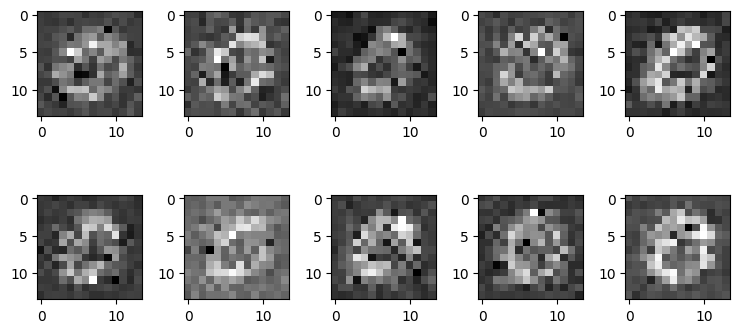

In [ ]:
flow = models[0]
flow.eval()
samples = flow.sample(10).detach().cpu()
samples = torch.unflatten(samples, dim=1, sizes=(14, 14))
plot_mnist(samples, 2, 5)

In [ ]:
def get_accuracy(data_loader, models, device, bits, img_size):
    total_samples = 0
    top1_correct = 0
    top3_correct = 0
    top5_correct = 0
    bits_representation = 2 ** bits

    for x, y_true in data_loader:
        x = x.to(device)
        y_true = y_true.to(device)
        batch_size = x.size(0)
        x = x.flatten(start_dim=1)
        x = x * (bits_representation - 1)
        x = x / bits_representation

        log_probs = []
        for digit in range(10):
            model = models[digit]
            model.eval()
            with torch.no_grad():
                log_px = model.log_prob(x) - np.log(bits_representation) * (img_size * img_size)
                log_probs.append(log_px.unsqueeze(1))

        log_probs = torch.cat(log_probs, dim=1)
        _, top_k_indices = torch.topk(log_probs, k=5, dim=1)

        y_true = y_true.view(-1, 1)
        correct_top1 = (top_k_indices[:, 0] == y_true.squeeze()).sum().item()
        correct_top3 = (top_k_indices[:, :3] == y_true).any(dim=1).sum().item()
        correct_top5 = (top_k_indices[:, :5] == y_true).any(dim=1).sum().item()

        top1_correct += correct_top1
        top3_correct += correct_top3
        top5_correct += correct_top5
        total_samples += batch_size

    accuracy = {
        'top1': top1_correct / total_samples,
        'top3': top3_correct / total_samples,
        'top5': top5_correct / total_samples
    }

    return accuracy

In [ ]:
models = {}
for digit in range(10):
    models[digit] = RealNVP(img_size * img_size, num_steps=num_transforms).to(device)

In [ ]:
accuracy = get_accuracy(test_loader, models, device, bits, img_size)
print(f"Top-1 Accuracy: {accuracy['top1']:.4f}")
print(f"Top-3 Accuracy: {accuracy['top3']:.4f}")
print(f"Top-5 Accuracy: {accuracy['top5']:.4f}")

Top-1 Accuracy: 0.0000
Top-3 Accuracy: 0.0000
Top-5 Accuracy: 1.0000


## Bonus zadatak

Predložite implementaciju konvolucijskog normalizirajućeg toka.